In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 23.2 MB 113 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import sklearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import random
import seaborn as sns

In [104]:
def generateRandomRGB(n):
  colors = [(random.uniform(0.0, 1.0), random.uniform(0.0, 1.0), 
               random.uniform(0.0, 1.0)) for i in range(n)]
  return colors

def plotData(X, y, colors=None, title='', xlabel='', ylabel=''):
    unique_classes = np.unique(y)
    n_classes = len(unique_classes)
    if(colors is None):
      colors = generateRandomRGB(n_classes)
        
    for class_index in range(n_classes):
      plt.scatter(X[y == unique_classes[class_index],0], X[y == unique_classes[class_index],1], 
                  label=unique_classes[class_index], color=colors[class_index],
                  s=100)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
pokemon_train = pd.read_csv("Pokemon_train.csv")
pokemon_test = pd.read_csv("Pokemon_test.csv")

X_train, y_train = pokemon_train.iloc[:, :-1], pokemon_train.iloc[:, -1]
X_test, y_test = pokemon_test.iloc[:, :-1], pokemon_test.iloc[:, -1]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

## Apply Gaussian Naive Bayes Baseline Model

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [10]:
baseline_gnb_clf = GaussianNB()
baseline_gnb_clf.fit(X_train, y_train)

baseline_gnb_preds = baseline_gnb_clf.predict(X_test)
baseline_gnb_accuracy = accuracy_score(y_test, baseline_gnb_preds)
print("Gaussian NB Accuracy = {:.2f}%".format(baseline_gnb_accuracy))

Gaussian NB Accuracy = 0.90%


## Apply SVM Baseline Model

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [12]:
baseline_svc_clf = SVC(probability=True, gamma='auto')
baseline_svc_clf.fit(X_train, y_train)
baseline_svc_preds = baseline_svc_clf.predict(X_test)
baseline_svc_acc = accuracy_score(baseline_svc_preds, y_test)

print("SVM Accuracy = {:.2f}%".format(baseline_svc_acc))

SVM Accuracy = 0.91%


In [13]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]}

svm_grid = GridSearchCV(SVC(), param_grid, verbose=1)
svm_grid.fit(X_train, y_train)

svm_preds = svm_grid.best_estimator_.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
print("SVM tuned Accuracy = {:.2f}%".format(svm_accuracy))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVM tuned Accuracy = 0.99%


# Apply T-SNE to Visualize the Data

In [14]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


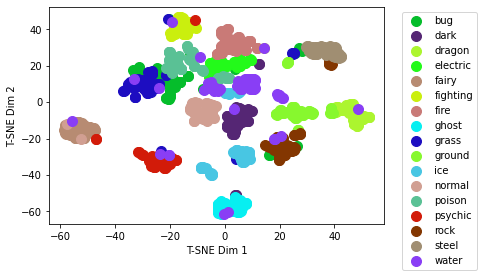

In [105]:
tsne = TSNE(n_components=2, random_state=0)
X_train_reduced = tsne.fit_transform(X_train)

colors = generateRandomRGB(len(y_train.unique()))
plotData(X_train_reduced, y_train, colors, xlabel='T-SNE Dim 1', ylabel='T-SNE Dim 2')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


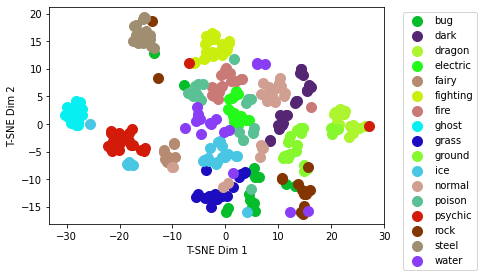

In [106]:
X_test_reduced = tsne.fit_transform(X_test)
plotData(X_test_reduced, y_test, colors, xlabel='T-SNE Dim 1', ylabel='T-SNE Dim 2')

# Apply KMeans

In [107]:
from sklearn.cluster import KMeans

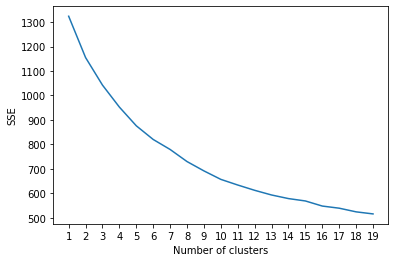

In [108]:
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(X_train)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [109]:
X_train_kmeans = X_train.copy()
kmeans = KMeans(n_clusters=10, max_iter=1000, random_state=0).fit(X_train)
X_train_kmeans["centroid"] = kmeans.fit_predict(X_train)

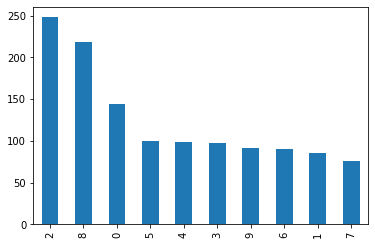

In [110]:
X_train_kmeans["centroid"].value_counts().plot.bar()

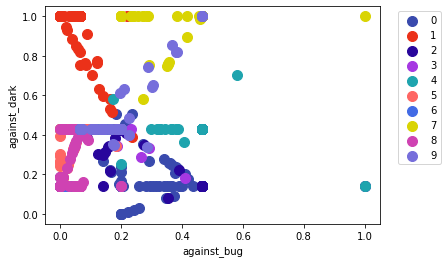

In [111]:
# Plot the first 2 features of X_train with their clusters
plotData(X_train.to_numpy(), X_train_kmeans["centroid"], xlabel=X_train.columns[0], ylabel=X_train.columns[1])

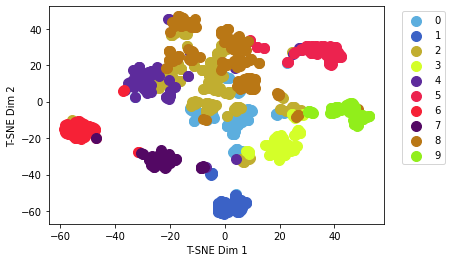

In [116]:
# Plot the first 2 features of X_train with their clusters
plotData(X_train_reduced, X_train_kmeans["centroid"], xlabel='T-SNE Dim 1', ylabel='T-SNE Dim 2')

In [117]:
import plotly.express as px

fig = px.scatter_matrix(
    X_train_kmeans,
    dimensions=X_train_kmeans.columns[:5],
    color="centroid",
    width=800,
    height=800
)
fig.update_traces(diagonal_visible=True)
fig.show()

# Tuning LDA n_components with Baseline Models

In [118]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [119]:
def tune_lda(clf, X_trian, y_train, X_test, y_test, n_min, n_max):
    accs = []
    for i in range(n_min, n_max):
        print(f'n_components = {i}')
        lda = LinearDiscriminantAnalysis(n_components=i)
        X_train_lda = lda.fit_transform(X_train, y_train)
        X_test_lda = lda.transform(X_test)
        clf.fit(X_train_lda, y_train)
        preds = clf.predict(X_test_lda)
        accuracy = accuracy_score(y_test, preds)
        accs.append(accuracy)
    return accs

def visualize_accs(baseline_acc, tuned_accs, clf_name, min_feats=0, operation='PCA', xlabel='n_components'):
    plt.plot(range(min_feats, min_feats+len(tuned_accs)), tuned_accs, label=f'{operation} {clf_name} Accuracy')
    plt.plot(range(min_feats, min_feats+len(tuned_accs)), [baseline_acc]*len(tuned_accs), label=f'Baseline {clf_name} Accuracy')
    plt.xlabel(xlabel)
    plt.xticks(range(min_feats, min_feats+len(tuned_accs)))
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

n_components = 1
n_components = 2
n_components = 3
n_components = 4
n_components = 5
n_components = 6
n_components = 7
n_components = 8
n_components = 9
n_components = 10
n_components = 11
n_components = 12
n_components = 13
n_components = 14
n_components = 15
n_components = 16


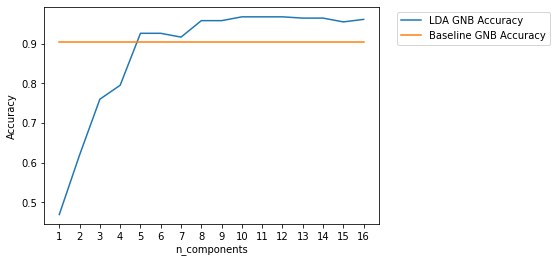

In [120]:
gnb = GaussianNB()
gnb_lda_accs = tune_lda(gnb, X_train, y_train, X_test, y_test, 1, 17)
visualize_accs(baseline_gnb_accuracy, gnb_lda_accs, "GNB", min_feats=1, operation='LDA')

In [ ]:
for i, j in enumerate(gnb_lda_accs):
  print(i+1, j)

1 0.4696485623003195
2 0.6198083067092651
3 0.7603833865814696
4 0.7955271565495208
5 0.9265175718849841
6 0.9265175718849841
7 0.9169329073482428
8 0.9584664536741214
9 0.9584664536741214
10 0.9680511182108626
11 0.9680511182108626
12 0.9680511182108626
13 0.9648562300319489
14 0.9648562300319489
15 0.9552715654952076
16 0.9616613418530351


With 8 LDA components, GNB achieves accuracy of  95.8% on test data.

n_components = 1


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 2


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 3


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 4


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 5


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 6


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 7


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 8


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 9


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 10


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 11


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 12


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 13


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 14


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 15


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_components = 16


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



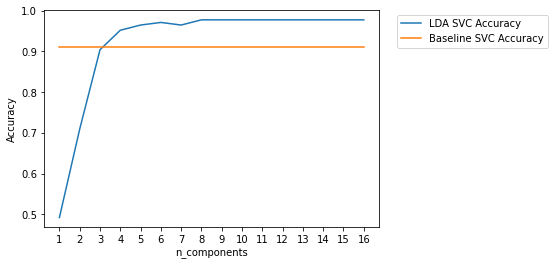

In [ ]:
svc_lda_accs = tune_lda(baseline_svc_clf, X_train, y_train, X_test, y_test, 1, 17)
visualize_accs(baseline_svc_acc, svc_lda_accs, "SVC", min_feats=1, operation='LDA')

In [ ]:
for i, j in enumerate(svc_lda_accs):
  print(i+1, j)

1 0.49201277955271566
2 0.7092651757188498
3 0.9041533546325878
4 0.952076677316294
5 0.9648562300319489
6 0.9712460063897763
7 0.9648562300319489
8 0.9776357827476039
9 0.9776357827476039
10 0.9776357827476039
11 0.9776357827476039
12 0.9776357827476039
13 0.9776357827476039
14 0.9776357827476039
15 0.9776357827476039
16 0.9776357827476039


With 6 lda components, SVM achieves accuracy of 97% on test data.

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=7)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Feature Selection by Filtering

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif

In [ ]:
def select_features(X_train, y_train, X_test, y_test, clf, fs):
    fs.fit(X_train, y_train)
    X_train_best_features = fs.transform(X_train)
    X_test_best_features = fs.transform(X_test) 
    clf.fit(X_train_best_features, y_train)
    y_pred = clf.predict(X_test_best_features)
    acc = accuracy_score(y_test, y_pred)
    return acc

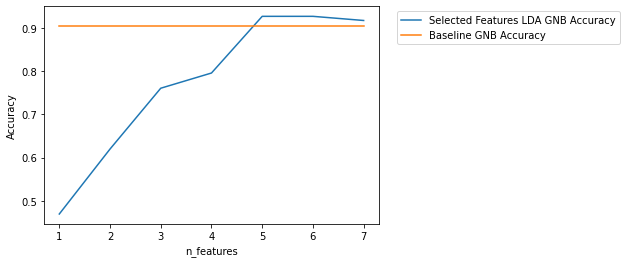

In [ ]:
gnb_lda_accs = []
for n in range(1, 8):
    fs =  SelectKBest(f_classif, k=n)
    acc = select_features(X_train_lda, y_train, X_test_lda, y_test, baseline_gnb_clf, fs)
    gnb_lda_accs.append(acc)
visualize_accs(baseline_gnb_accuracy, gnb_lda_accs, "GNB", operation='Selected Features LDA', min_feats=1, xlabel='n_features')

In [ ]:
gnb_lda_accs

[0.4696485623003195,
 0.6198083067092651,
 0.7603833865814696,
 0.7955271565495208,
 0.9265175718849841,
 0.9265175718849841,
 0.9169329073482428]

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names

C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441

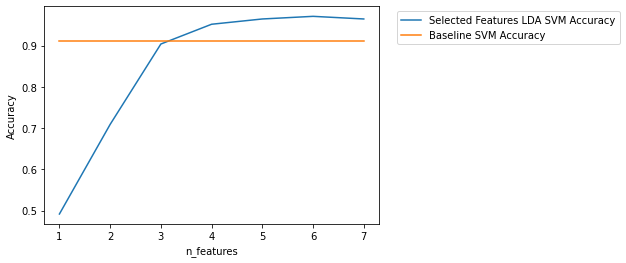

In [ ]:
svm_lda_accs = []
for n in range(1, 8):
    fs =  SelectKBest(f_classif, k=n)
    acc = select_features(X_train_lda, y_train, X_test_lda, y_test, baseline_svc_clf, fs)
    svm_lda_accs.append(acc)
visualize_accs(baseline_svc_acc, svm_lda_accs, "SVM", operation='Selected Features LDA', min_feats=1, xlabel='n_features')

In [ ]:
svm_lda_accs

[0.49201277955271566,
 0.7092651757188498,
 0.9041533546325878,
 0.952076677316294,
 0.9648562300319489,
 0.9712460063897763,
 0.9648562300319489]

# Feature Selection by Wrapping

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

n_features = 2


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



n_features = 3


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



n_features = 4


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



n_features = 5


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



n_features = 6


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



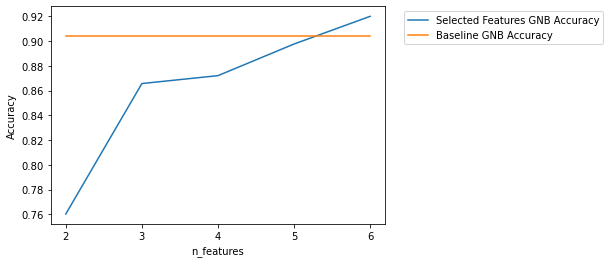

In [ ]:
gnb_wrapping_accs = []
for n in range(2,7):
    print(f"n_features = {n}")
    fs = SequentialFeatureSelector(baseline_gnb_clf, n_features_to_select=n)
    acc = select_features(X_train_lda, y_train, X_test_lda, y_test, baseline_gnb_clf, fs)
    gnb_wrapping_accs.append(acc)

gnb_wrapper_best_n = np.argmax(gnb_wrapping_accs) + 2
visualize_accs(baseline_gnb_accuracy, gnb_wrapping_accs, "GNB", operation='Selected Features', min_feats=2, xlabel='n_features')

In [ ]:
print(gnb_wrapping_accs)

[0.7603833865814696, 0.865814696485623, 0.8722044728434505, 0.8977635782747604, 0.9201277955271565]


n_features = 2


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_features = 3


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_features = 4


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_features = 5


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



n_features = 6


C:\Users\Mohamed\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



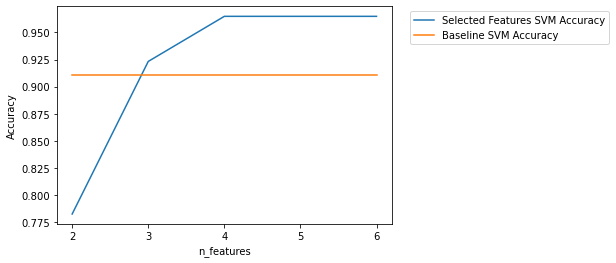

In [ ]:
svc_wrapping_accs = []
for n in range(2, 7):
    print(f"n_features = {n}")
    fs = SequentialFeatureSelector(baseline_svc_clf, n_features_to_select=n)
    acc = select_features(X_train_lda, y_train, X_test_lda, y_test, baseline_svc_clf, fs)
    svc_wrapping_accs.append(acc)

svc_wrapper_best_n = np.argmax(svc_wrapping_accs) + 2
visualize_accs(baseline_svc_acc, svc_wrapping_accs, "SVM", operation='Selected Features', min_feats=2, xlabel='n_features')


In [ ]:
print(svc_wrapping_accs)

# We choose LDA with 8 components as our best features. 

---



In [ ]:
clf = GaussianNB()
lda = LinearDiscriminantAnalysis(n_components=8)
X_train_best_features = lda.fit_transform(X_train, y_train)
X_test_best_features = lda.transform(X_test)

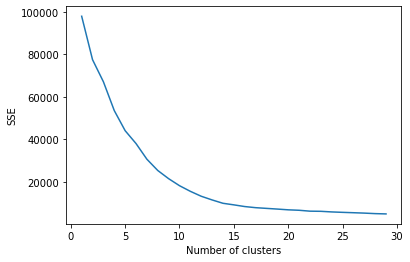

In [ ]:
sse = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit( X_train_best_features)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1, 30), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

# SOM algorithm with   Wrapping Methods

In [ ]:
#!pip install sklearn_som

In [ ]:
from sklearn_som.som import SOM
from minisom import MiniSom
from pylab import plot, axis, show, pcolor, colorbar, bone

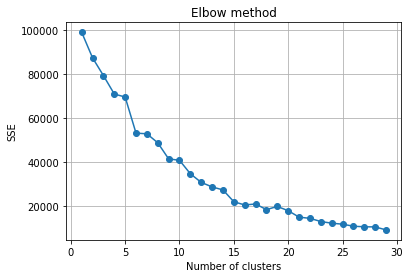

In [ ]:
sse = []
for k in range(1, 30):
    SOM_model= SOM(m=k, n=1, dim=X_train_best_features.shape[1],max_iter=3000)
    SOM_model.fit(X_train_best_features)
    sse.append(SOM_model.inertia_)
plt.figure()
plt.title("Elbow method")
plt.plot(range(1, 30), sse, marker = 'o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.grid(True)

In [ ]:
y_label=["bug",'dark',"dragon","electric","fairy","fighting","fire","ghost",
         "grass","ground","ice","normal","poison","psychic","rock","steel","water"]
labels=np.array(y_train)
labels
for x in range(17):
    labels[labels==y_label[x]]=x
labels

array([14, 14, 16, ..., 10, 0, 2], dtype=object)

In [ ]:
som_grid_rows = 17
som_grid_columns = 17
iterations = 20000
sigma = 1
learning_rate = 0.5

# # plot the initial Neauron positions 

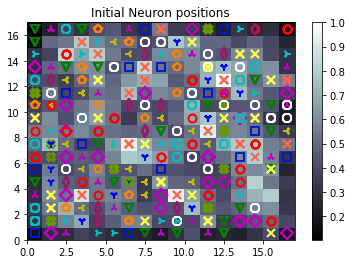

In [ ]:
som = MiniSom(x = som_grid_rows, y = som_grid_columns, input_len=8, sigma=sigma, learning_rate=learning_rate)
som.random_weights_init(X_train_best_features)
bone()
pcolor(som.distance_map().T)       # Distance map as background
colorbar()

markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', 'X',"r","x","d",'g',"2","4","8"]
colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3),
          "m", (0.4,0.6,0),(.6,1,.3),(1,.4,.3),(0.6,0.1,.4),(0.7,0.4,.2),"m","c","w"]
I=0
for cnt,xx in enumerate(X_train_best_features):
   w = som.winner(xx) 
   
   plot(w[0]+.5,w[1]+.5,markers[labels[cnt]],    
   markerfacecolor='None', markeredgecolor=colors[labels[cnt]], 
   markersize=8, markeredgewidth=2)
   axis([0,som.get_weights().shape[0],0,som.get_weights().shape[1]])
plt.title("Initial Neuron positions")
show()
   


# Training model 

In [ ]:
som.train(X_train_best_features, iterations)

# Plot the Final Neauron positions 

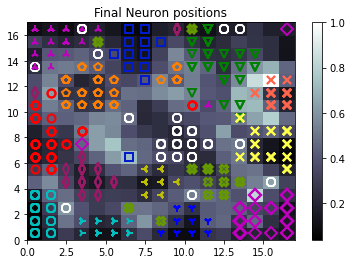

In [ ]:
bone()
pcolor(som.distance_map().T)       
colorbar()

markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', 'X',"r","x","d",'g',"2","4","8"]
colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3),
          "m", (0.4,0.6,0),(.6,1,.3),(1,.4,.3),(0.6,0.1,.4),(0.7,0.4,.2),"m","c","w"]
I=0
for cnt,xx in enumerate(X_train_best_features):
   w = som.winner(xx) 
   
   plot(w[0]+.5,w[1]+.5,markers[labels[cnt]],    
   markerfacecolor='None', markeredgecolor=colors[labels[cnt]], 
   markersize=8, markeredgewidth=2)
   axis([0,som.get_weights().shape[0],0,som.get_weights().shape[1]])
plt.title("Final Neuron positions")
show()
    
    



# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
N_CLUSTERS = 17
eps_list=[]
min_samples_list=[]
n_clusters_=[]
silhouette_avg=[]
for i in range(2,15,1):#2-15
    for j in np.arange(0.2,3,0.1): #(0.2-3
        model=DBSCAN(eps=j, min_samples=i)
        model.fit(X_train_best_features)
        silhouette_avg.append(silhouette_score(X_train_best_features, model.labels_))
        min_samples_list.append(i)
        eps_list.append(j)
        n_clusters_.append(len(set(model.labels_)) - (1 if -1 in model.labels_ else 0))#remove outlier class (-1)

In [ ]:
matches = sum([1 for x in n_clusters_ if x == N_CLUSTERS])
print(f"Number of eps and min_samples with n_clusters of {N_CLUSTERS} is {matches}")

Number of eps and min_samples with n_clusters of 17 is 17


In [ ]:
eps=[]
min_sample=[]
for i in range(len(n_clusters_)):
 
  if  n_clusters_[i]== N_CLUSTERS and silhouette_avg[i] >= .48   :
    eps.append(eps_list[i]) 
    min_sample.append(min_samples_list[i])
    print("sillout= ",silhouette_avg[i])
    print("min_samples = ",min_samples_list[i])
    print("eps = ",eps_list[i],"\n_________")


sillout=  0.5134467242790058
min_samples =  5
eps =  2.500000000000001 
_________
sillout=  0.5172464704047118
min_samples =  5
eps =  2.700000000000001 
_________
sillout=  0.509324869428076
min_samples =  6
eps =  2.500000000000001 
_________
sillout=  0.4880937207741083
min_samples =  8
eps =  2.000000000000001 
_________
sillout=  0.4891251813007102
min_samples =  8
eps =  2.1000000000000005 
_________
sillout=  0.4916487509400583
min_samples =  8
eps =  2.200000000000001 
_________
sillout=  0.48447565912351875
min_samples =  9
eps =  2.000000000000001 
_________
sillout=  0.4891251813007102
min_samples =  9
eps =  2.1000000000000005 
_________
sillout=  0.4947466278247503
min_samples =  11
eps =  1.9000000000000006 
_________
sillout=  0.49375083201884323
min_samples =  12
eps =  1.9000000000000006 
_________


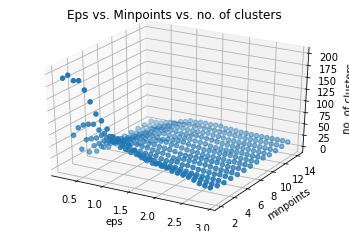

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d') 
ax.scatter3D(eps_list ,min_samples_list , n_clusters_, 'Green')
ax.set_title("Eps vs. Minpoints vs. no. of clusters")
ax.set_xlabel("eps")
ax.set_ylabel("minpoints")
ax.set_zlabel("no. of clusters")
plt.show()